In [1]:
import os
import sys
import math
import re
import time
import functools
import itertools
from abc import ABC
from dataclasses import dataclass, field
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
from scipy.linalg import solve
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
!{sys.executable} -m pip install pyfinance -q
from pyfinance.options import BSM as BSMAux
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Add any general utility functions as static member functions to this class. They can be called as `Util.fn`.

In [2]:
class Util:
    def __init__(self):
        raise TypeError("Non-instantiable class")
        
    def __new__(self, *args, **kwargs):
        raise TypeError("Non-instantiable class")
        
    @staticmethod
    def make_regex_group_disjunction(coll):
        return "|".join(map(lambda x: f"({str(x)})", coll))

In [3]:
class OptionsData:
    data_dir = "data"
    default_filename = "isx2010C.xls"
    
    def __init__(self, filename=default_filename, clean=True):
        filepath = os.path.join(self.data_dir, filename)
        if not os.path.isfile(filepath):
            faulty_filepath = filepath
            filepath = os.path.join(self.data_dir, self.default_filename)
            print(f"[{type(self).__name__}] Warning: could not find {faulty_filepath!r}; proceeding with {filepath!r}")
        self.__sheet_df_dict = pd.read_excel(filepath, sheet_name=None)
        sheets = list(self.__sheet_df_dict.keys())
        self.__sheet_succ = dict(zip(sheets, sheets[1:] + [sheets[-1]]))
        if clean:
            for key, val in self.__sheet_df_dict.items():
                self.__sheet_df_dict[key] = self.__clean_df(val)
                
    def __get_item__(self, key):
        return self.__sheet_df_dict[key]
    
    def get_sheet_names(self):
        return list(self.__sheet_succ.keys())
    
    def get_sheet_df_dict(self):
        return self.__sheet_df_dict
    
    def get_next_sheet_name(self, sheet_name):
        assert sheet_name in self.__sheet_succ
        return self.__sheet_succ[sheet_name]
    
    def get_df(self, E=None, sheet_name=""):
        if not sheet_name:
            sheet_name = list(self.__sheet_df_dict.keys())[0]
            print(f"[{type(self).__name__}] Warning: sheet name not specified; proceeding with {sheet_name!r}")
        df = self.__sheet_df_dict[sheet_name]
        common = ["T", "T_norm", "S", "r"]
        if not E:
            return df[[*common, *filter(lambda x: re.match(r"[0-9]+", x), df.columns)]]
        strikes = E if type(E) is list or type(E) is tuple else [E]
        cols = [*common, *map(lambda x: str(int(x)), strikes)]
        return df[cols]
    
    def __clean_df(self, df):
        # Discard rows where no options data is available.
        df = df.dropna(how="all")
        # Rename the columns according to the following convention:
        #  T = Time to Maturity
        #  S = Price of the Underlying
        #  r = Risk-Free Interest Rate
        df = df.rename(lambda x: self.__rename_df_cols(str(x), df), axis="columns")
        # Adjust the interest rate properly.
        df["r"] = df["r"] / 100
        # Add new column with annual-normalized T (252 = no. trading days in a year).
        df["T_norm"] = df["T"] / 252
        # Re-arrange the columns.
        common = ["S", "r", "T", "T_norm"]
        cols = [*common, *filter(lambda x: re.search("[0-9]+", x), df.columns.astype(str))]
        return df[cols]
    
    def __rename_df_cols(self, col_name, df):
        ncol = len(df.columns)
        # Time to maturity | (price of the underlying | risk-free rate).
        regex = r"(?P<T>[0-9]+(-[0-9]{2}){2} ([0-9]{2}:){2}[0-9]{2})|(?P<Sr>Unnamed: (?P<idx>[0-9]+))"
        match = re.match(regex, col_name)
        if not match:
            return col_name
        if match["T"]:
            return "T"
        elif match["Sr"]:
            col_idx = int(match["idx"])
            # Third last depicts the price of the underlying...
            if col_idx == ncol - 3:
                return "S"
            # ...and the second last the risk free rate.
            elif col_idx == ncol - 2:
                return "r"


In [35]:
data = OptionsData("isx2010C.xls")
data.get_sheet_names()

['isx15012010C',
 'isx19022010C',
 'isx17122010C',
 'isx19112010C',
 'isx15102010C',
 'isx17092010C',
 'isx20082010C',
 'isx16072010C',
 'isx18062010C',
 'isx21052010C',
 'isx16042010C',
 'isx19032010C']

A class encapsulating the Black-Scholes-Merton model and related computations, such as Greeks. Can create instances from `pd.Series` objects (as returned by pd.DataFrame.iterrows) via the `BSM.make_from_series` factory method.

In [5]:
@dataclass(frozen=True)
class BSM:
    S: float
    E: float
    r: float
    T: float
    C_obs: float
    sigma: float = 1.0
    d1: float = field(init=False)
    d2: float = field(init=False)
    
    def __post_init__(self):
        S, E, r, T, C_obs, sigma = self.S, self.E, self.r, self.T, self.C_obs, self.sigma
        sigma = BSMAux(S0=S, K=E, T=T, r=r, sigma=0.5, kind='call').implied_vol(C_obs)
        object.__setattr__(self, "sigma", sigma)
        eps = np.finfo(float).eps
        d1 = (math.log(S / E) + (r + 0.5 * self.sigma**2) * T) / (sigma * math.sqrt(T) + eps)
        object.__setattr__(self, "d1", d1)
        d2 = self.d1 - self.sigma * math.sqrt(T)
        object.__setattr__(self, "d2", d2)
        
    @staticmethod    
    def make_from_dict(d, E):
        return BSM(d["S"], int(E), d["r"], d["T_norm"], d[E])
    
    @staticmethod
    def make_from_series(ser, E, sigma=1.0):
        ser = ser.filter(regex=Util.make_regex_group_disjunction(["S", int(E), "r", "T_norm"]), axis="index")
        assert ser.shape[0] == 4, f"[{type(self).__name__}] Error: The Series should have an index of form [S, E, r, T_norm], got {ser.index}."
        S, r, T, C_obs = ser.array
        return BSM(S, E, r, T, C_obs, sigma=sigma)
    
    @functools.cached_property
    def delta(self):
        return norm.cdf(self.d1)
    
    @functools.cached_property
    def gamma(self):
        return norm.pdf(self.d1) / (self.S * self.sigma * math.sqrt(self.T))
    
    @functools.cached_property
    def theta(self):
        S, E, r, T, sigma, d1, d2 = self.S, self.E, self.r, self.T, self.sigma, self.d1, self.d2
        return -0.5 * S * norm.pdf(d1) * sigma / math.sqrt(T) - r * E * math.exp(-r * T) * norm.cdf(d2)
    
    @functools.cached_property
    def vega(self):
        return self.S * math.sqrt(self.T) * norm.pdf(self.d1)


In [6]:
test = data.get_df()
td = test.to_dict("index")
for t, row in td.items():
    print(f"Day {t}")
    strikes = list(filter(lambda x: re.match(r"[0-9]+", x), row.keys()))
    BSMs = {}
    for E in strikes:
        BSMs[E] = BSM.make_from_dict(row, E)
    greeks = pd.DataFrame(index=strikes)
    greeks["delta"] = pd.Series([BSMs[E].delta for E in greeks.index], index=greeks.index)
    greeks["gamma"] = pd.Series([BSMs[E].gamma for E in greeks.index], index=greeks.index)
    greeks["vega"] = pd.Series([BSMs[E].vega for E in greeks.index], index=greeks.index)
    print(greeks[greeks > 0.001])
    print("-" * 50)
    break


[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
Day 0
        delta     gamma        vega
340  0.979830       NaN   13.997796
345       NaN       NaN         NaN
350       NaN       NaN         NaN
355       NaN       NaN         NaN
360  0.968614       NaN   20.274473
365       NaN       NaN         NaN
370       NaN       NaN         NaN
375       NaN       NaN         NaN
380  0.951548  0.001256   28.869144
385       NaN       NaN         NaN
390       NaN       NaN         NaN
395       NaN       NaN         NaN
400  0.918179  0.001963   43.403146
405       NaN       NaN         NaN
410       NaN       NaN         NaN
415       NaN       NaN         NaN
420  0.872182  0.002876   60.011561
425       NaN       NaN         NaN
430       NaN       NaN         NaN
435       NaN       NaN         NaN
440  0.807413  0.004019   78.539065
445       NaN       NaN         NaN
450       NaN       NaN         NaN
455       NaN       NaN         NaN
460  0.716861 

In [7]:
t = 0
strike_step = 5
S = td[t]["S"]
S
strikes = list(filter(lambda x: re.match(r"\d+", x), td[t].keys()))
strike_to_buy = strikes[np.argmin(np.abs(np.array(strikes, dtype=np.int64) - S))]
strike_to_buy
Gs = greeks[greeks > 0.001].dropna(how='all')
strike_to_buy
Gs = Gs.fillna(0)
print(Gs)
# G*w = p
p = Gs.loc[strike_to_buy].to_numpy()[0]
G = p
res = solve(G, p)
p - res*p

        delta     gamma        vega
340  0.979830  0.000000   13.997796
360  0.968614  0.000000   20.274473
380  0.951548  0.001256   28.869144
400  0.918179  0.001963   43.403146
420  0.872182  0.002876   60.011561
440  0.807413  0.004019   78.539065
460  0.716861  0.005282   97.142809
480  0.600874  0.006448  110.829038
500  0.463360  0.007058  114.026100
520  0.320293  0.006735  102.685257


KeyError: '490'

In [24]:
'''
test = data.get_df()
td = test.to_dict("index")
for t, row in td.items():
    print(f"Day {t}")
    strikes = list(filter(lambda x: re.match(r"[0-9]+", x), row.keys()))
    BSMs = {}
    for E in strikes:
        BSMs[E] = BSM.make_from_dict(row, E)
    greeks = pd.DataFrame(index=strikes)
    greeks["delta"] = pd.Series([BSMs[E].delta for E in greeks.index], index=greeks.index)
    greeks["gamma"] = pd.Series([BSMs[E].gamma for E in greeks.index], index=greeks.index)
    greeks["vega"] = pd.Series([BSMs[E].vega for E in greeks.index], index=greeks.index)
    print(greeks[greeks > 0.001])
    print("-" * 50)
    break
'''

class Hedger:
    @dataclass
    class HedgingStats:
        cost_basis: float
        mse: float = 0.0
        total_cost: float = 0.0
        hedge_values: list = field(default_factory=list)
        non_hedge_values: list = field(default_factory=list)
        
        def __repr__(self):
            return (f"[Hedger.{type(self).__name__}]: "
                    f"Assuming a cost basis of {self.cost_basis*100:.2f}%, mean-squared error "
                    f"of hedging was {self.mse:.2f}, and the total costs were ${self.total_cost:.2f}.")
    
    @dataclass
    class DeltaState:
        long: float
        short: float
        delta: float

    def delta_hedge(self, data, sheet_name="", portfolio_size=2, schedule=2, cost_basis=0.01, start_date=0):
        df = data.get_df(sheet_name=sheet_name)
        
        # We consider at-the-money options.
        day0 = df.iloc[start_date]
        strikes = day0.dropna().filter(regex=r"\d+").index
        option_value_ser = pd.Series(data=strikes, index=strikes, dtype=int).apply(lambda E: abs(day0.S - E))
        strikes_considered = option_value_ser.iloc[np.argsort(option_value_ser)[:portfolio_size]]
        print((f"[{type(self).__name__}] Info: "
               f"Considering a position in call(s) with strike price(s) of {', '.join(strikes_considered.index)}"))
        
        # Compute and save state for the required computations.
        BSMs = {E: BSM(day0.S, int(E), day0.r, day0.T_norm, day0[E]) for E in strikes_considered.index}
        deltas = np.sum(np.nan_to_num(list(map(lambda x: x.delta, BSMs.values()))))
        longs = day0[strikes_considered.index].sum()
        state_prev = Hedger.DeltaState(longs, deltas * day0.S, deltas)
        stats = Hedger.HedgingStats(cost_basis=cost_basis)
        stats.total_cost += cost_basis * state_prev.short

        # Simulate trading with the provided data and perform hedging.
        day1_onwards = df.iloc[start_date+1:-1].to_dict("index")
        squared_errors = []
        for t, row in day1_onwards.items():
            BSMs = {E: BSM.make_from_dict(row, E) for E in strikes_considered.index}
            longs = sum(map(lambda x: x.C_obs, BSMs.values()))
            state = Hedger.DeltaState(longs, state_prev.delta * df.iloc[t].S, state_prev.delta)
            dlong = state.long - state_prev.long
            dshort = state.short - state_prev.short
            squared_errors.append((dlong - dshort)**2)
            stats.hedge_values.append(state.long-state.short-stats.total_cost)
            stats.non_hedge_values.append(state.long)
            # Rehedge?
            if t % schedule == 0:
                deltas = np.sum(np.nan_to_num(list(map(lambda x: x.delta, BSMs.values()))))
                state.short = deltas * df.iloc[t].S
                state.delta = deltas
                #transaction costs 
                stats.total_cost += abs(cost_basis * (state_prev.delta - state.delta) * df.iloc[t].S)
            state_prev = state

        stats.mse = np.mean(squared_errors)
        return stats
        
    def delta_vega_hedge_single(self, data, schedule=2, sheet_name=""):
        df = data.get_df(sheet_name=sheet_name)
        n_options_considered = 2
        
        # We consider at-the-money options.
        day0 = df.iloc[0]
        strikes = day0.dropna().filter(regex=r"\d+").index
        option_value_ser = pd.Series(data=strikes, index=strikes, dtype=int).apply(lambda E: abs(day0.S - E))
        Es = option_value_ser.iloc[np.argsort(option_value_ser)[:n_options_considered]]
        E = Es.index[0]
        print(f"[{type(self).__name__}] Info: Considering a position in a call with a strike price of {E}")
        print(E)

In [36]:
h = Hedger()
all_hedges = []
sheet_name = ""
start_date = data.get_df().iloc[0][0]
print()
for i in range(0,int(start_date*0.6+1),5):
    all_hedges.append((h.delta_hedge(data, portfolio_size=2, start_date = i, sheet_name=sheet_name),i))



[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'

[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
[Hedger] Info: Considering a position in call(s) with strike price(s) of 500, 480


/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (


[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
[Hedger] Info: Considering a position in call(s) with strike price(s) of 500, 480
[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
[Hedger] Info: Considering a position in call(s) with strike price(s) of 480, 500
[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
[Hedger] Info: Considering a position in call(s) with strike price(s) of 500, 480
[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
[Hedger] Info: Considering a position in call(s) with strike price(s) of 510, 500
[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
[Hedger] Info: Considering a position in call(s) with strike price(s) of 490, 500
[OptionsData] Warning: sheet name not specified; proceeding with 'isx15012010C'
[Hedger] Info: Considering a position in call(s) with strike price(s) of 490, 480
[OptionsData] Warning: sheet

In [37]:
to_maturity, mses, costs, strike_price = [],[],[],[]
for i in all_hedges:
    to_maturity.append(start_date-i[1])
    mses.append(i[0].mse)
    costs.append(i[0].total_cost)
    

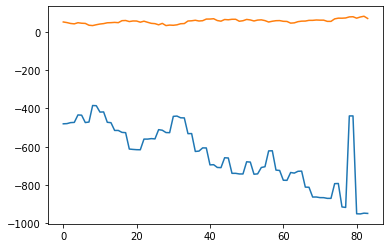

In [43]:
for i, data_value in enumerate(all_hedges[0][0].hedge_values):
    #find way too large values
    if data_value > 1000:
        print(i)
plt.plot(all_hedges[0][0].hedge_values)
plt.plot(all_hedges[0][0].non_hedge_values)

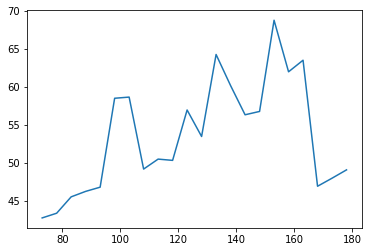

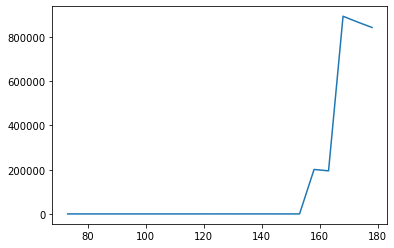

In [65]:
plt.plot(to_maturity,costs) 
plt.show()
plt.plot(to_maturity,mses) 
plt.show()

ValueError: x and y must be equal-length 1-D arrays

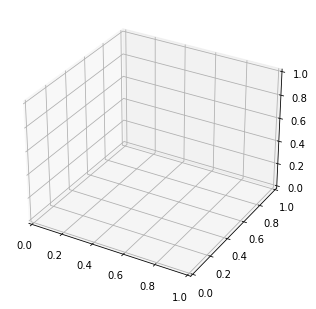

In [54]:

"""
fig = plt.figure()
ax.plot_trisurf(to_maturity, strike_price, costs, cmap=cm.coolwarm, linewidth=0.2)
ax.view_init(elev=30, azim=45)
ax.set_xlabel("Days to maturity in the beginning")
ax.set_ylabel("Strike price")
ax.set_zlabel("Total hedging cost")
plt.show()
"""

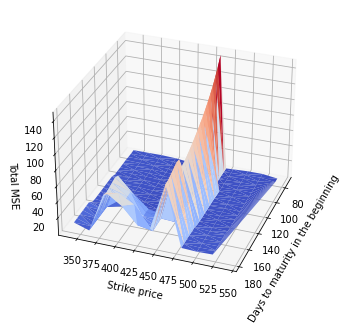

In [40]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(to_maturity, strike_price, mses, cmap=cm.coolwarm, linewidth=0.2)
ax.view_init(elev=30, azim = 20)
ax.set_xlabel("Days to maturity in the beginning")
ax.set_ylabel("Strike price")
ax.set_zlabel("Total MSE")
plt.savefig('foo.png', bbox_inches='tight')
plt.show()

In [ ]:
E = 500
schedule = 2
df = data.get_df(E).dropna()

import time

t0 = time.time()
# t = 0:
rows_iterator = df.iterrows()
_, row = next(rows_iterator)
bsm_prev = BSM.make_from_series(row, E)
long_prev = bsm_prev.C_obs
delta_factor = bsm_prev.delta
short_prev = delta_factor * bsm_prev.S

# 0 < t < T:
mse = 0.0
for t, row in rows_iterator:
    bsm = BSM.make_from_series(row, E)
    long = bsm.C_obs
    dlong = long - long_prev
    short = delta_factor * bsm.S
    dshort = short - short_prev
    mse += (dlong - dshort)**2
    long_prev = long
    bsm_prev = bsm
    # Rehedge?
    if t % schedule == 0:
        delta_factor = bsm.delta
        short_prev = delta_factor * bsm.S
    else:
        short_prev = short

mse /= df.shape[0]

t1 = time.time()
print(f"Took {(t1 - t0)*1000:.2f} ms")

In [64]:
print(f"Single option delta hedging {mse=:.2f}")

Single option delta hedging mse=nan
